This notebook includes functions for plotting the figures reported in the paper.

In [138]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [139]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [140]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [141]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

# Setting global variables 

In [142]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/tests/20240610_new_algo/og


In [143]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/10242023_v3.3/results"

# Directory to save figures
PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("../stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [144]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Bot params

## V1 algo
Data is a subset of joint effect experiments

### Baseline

In [145]:
folders = ["new_algo_v1_baseline", "new_algo_v1_baseline__5runs"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.8104260891910134]
values [0.807880547310041]
values [0.8202828031882079]
values [0.8075864519229385]
values [0.8206381074533696]
values [0.8042893619209703]
values [0.8091432856401033]
values [0.80403759931182]
values [0.7961968717635708]
values [0.8106476730303297]
Overall quality when there is no bots: 0.81


### Gamma

In [146]:
data = read_data(
    RES_DIR, folders=["new_algo_v1", "new_algo_v1_5runs", "new_algo_v1__5runs"]
)
# Reset quality cols
vary_gamma = reindex_cols(data, col_name_prefix="quality")
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
v1_gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9710782769685462, 0.9696455021171806, 0.9528059863376743, 0.9666632405440879, 0.9625532564278375, 0.9618158020935479, 0.9666580863572964]
values [0.9564677834819507, 0.9350359628403363, 0.9604515185544956, 0.9486287033036057, 0.9559183576706443, 0.9390867049796388, 0.9688235996768373]
values [0.9786191611093824, 0.9695098518310666, 0.9556724549294915, 0.9607224623735837, 0.959436353665131, 0.9878460981945442, 0.9726931975345666]
values [0.8281658821183879, 0.850771992556489, 0.8420598615832684, 0.8597447306457887, 0.8368987636499244, 0.8551437039497422, 0.8249321567347803]


### Theta

In [147]:
data = read_data(RES_DIR, folders=["algo_v1_theta", "algo_v1_theta__5runs"])
# Reset quality cols
vary_theta = reindex_cols(data, col_name_prefix="quality")

vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
v1_thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.8444056494150096, 0.8728824229664682, 0.850547369762091, 0.8560502369998823, 0.8272132100678888, 0.8569434464309428, 0.8371358829040341, 0.8593468058711153, 0.89842416098708, 0.8738763028732017]
values [0.9481150652496503, 0.9161245368259882, 0.937886260033915, 0.9082813711360122, 0.932780514964716, 0.9189601066279312, 0.9139982455692659, 0.9116875646813056, 0.921345718342144, 0.9189849630468508]
values [0.8789058680349172, 0.8877827692775249, 0.8612760769286182, 0.9088061774564656, 0.883445213697882, 0.8950712619011898, 0.8961853817507989, 0.9004001917484953, 0.8957445316351617, 0.871125328059768]
values [0.7278712360812158, 0.7484362274518209, 0.7578347762482401, 0.751466682419865, 0.7739199882775198, 0.7606814292904447, 0.7504864342429314, 0.7495411745405431, 0.7485063292517843, 0.7597075991896342]
values [0.7585247701014703, 0.7908949889981285, 0.7806924719668907, 0.7916046882938041, 0.7678657400004251, 0.7857168719938535, 0.7790285643201011, 0.7746701411192226, 0.7633121

## Phi

In [148]:
data = read_data(RES_DIR, folders=["algo_v1_phi", "algo_v1_phi__5runs"])
# Reset quality cols
vary_theta = reindex_cols(data, col_name_prefix="quality")
vary_phi = get_relative(data, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
x = vary_phi["phi"]
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
v1_phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.6780927757107733, 0.6513266784515147, 0.6817498596531477, 0.6976067099721243, 0.6706043368212239, 0.6725295005966766, 0.6918063769850382, 0.6955955514512303, 0.6737625148608072, 0.6821379334249472]
values [0.6471630488062283, 0.6767231435969016, 0.6451171237949319, 0.6431772028038342, 0.6493749006385583, 0.6363834001533106, 0.6448798918735866, 0.6632110029565279, 0.641693855191862, 0.6413561053890418]
values [0.6616114607528858, 0.6717552882084341, 0.6680750194666393, 0.6741832942750922, 0.6579852294034668, 0.6834284370367409, 0.6498339193488862, 0.6583886131411153, 0.65322278350084, 0.6497018411678303]
values [0.7106099260780256, 0.678434435397872, 0.6877087746651404, 0.6844070023316626, 0.6714130320940825, 0.697024898239167, 0.6996223572610941, 0.7135549377570023, 0.6969866393580918, 0.7211176477333029]
values [0.6517112983063613, 0.6337482632436819, 0.6428391538402812, 0.6381303845555643, 0.6382256602503404, 0.6443701296526624, 0.6526451894650149, 0.6617949442257934, 0.664

## Og algo

### Baseline

In [149]:
folders = ["og_algo_baseline", "og_algo_baseline__5runs"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.8142639642112088]
values [0.8120436241977925]
values [0.8131987656209596]
values [0.80450431196147]
values [0.8241185864339302]
values [0.8093784612692264]
values [0.8031529773499562]
values [0.8074115743420982]
values [0.7947150430703995]
values [0.8110585837784176]
Overall quality when there is no bots: 0.81


### Gamma

In [150]:
data = read_data(RES_DIR, folders=["og_algo", "og_algo__5runs"])
# Reset quality cols
vary_gamma = reindex_cols(data, col_name_prefix="quality")
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
og_gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9949893703982007, 0.9959411447043056, 1.0085193834929216, 0.9881502813648871, 0.9825867686954447, 0.9850793798223334]
values [0.9385405047539259, 0.9411537040600666, 0.9414070584706673, 0.929632231348452, 0.9108839627534416, 0.925160633080649]
values [1.00802977424971, 1.0152688910651835, 0.9864626529971381, 0.9912241367937465, 0.9935018935759745, 1.000429517112727]
values [0.6632059512624656, 0.6546846327026474, 0.6375131809441794, 0.6398733882565953, 0.6786889005689797, 0.6464158850956492]


### Theta

In [151]:
data = read_data(RES_DIR, folders=["og_algo_theta", "og_algo_theta__5runs"])
# Reset quality cols
vary_theta = reindex_cols(data, col_name_prefix="quality")

vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
og_thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.8907910677154353, 0.8402335113292732, 0.8608365329545853, 0.8737768000681706, 0.8622900553287656, 0.8566298438702915, 0.8753384516158585, 0.8651702838927496, 0.8898556347701213, 0.8708855718010794]
values [0.9277899761268239, 0.9104966543950144, 0.926909187998043, 0.9197038999662286, 0.9422979283973538, 0.8878189222195408, 0.9445038873338572, 0.9503963284603805, 0.9278527577127716, 0.907070409073081]
values [0.9084058309977233, 0.9002767818936298, 0.90479214231785, 0.9379353378321613, 0.8366372453300392, 0.946509707930904, 0.9069758785623171, 0.9120576966449235, 0.9012437250136409, 0.9438904757487864]
values [0.837725371664425, 0.8171782725810504, 0.8235460477380506, 0.8110731587419037, 0.8473488108991944, 0.81258172798891, 0.8070722208461408, 0.7567506840422882, 0.781773915410722, 0.8453284919624695]
values [0.7835185445732638, 0.8404648100410531, 0.8034622755007249, 0.8212326189360241, 0.828134723602166, 0.8457569470166733, 0.8544876387297317, 0.8370122804882895, 0.83968596

## Phi

In [152]:
data = read_data(RES_DIR, folders=["og_algo_phi", "og_algo_phi__5runs"])
# Reset quality cols
vary_theta = reindex_cols(data, col_name_prefix="quality")
vary_phi = get_relative(data, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
x = vary_phi["phi"]
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
og_phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.7740259054980155, 0.7872786299243564, 0.7494054727308456, 0.7543967026895522, 0.7597879838501611, 0.781526862957014, 0.8073412389289817, 0.7735446996661874, 0.7593737344355772, 0.7932806519722404]
values [0.7153361219873293, 0.7443813327457853, 0.7657375565488378, 0.749406716156005, 0.7337035981263844, 0.7572337358199165, 0.7395318479179649, 0.7488293141852992, 0.731993911440371, 0.7323356044010312]
values [0.7228204346880506, 0.7042961215660178, 0.7255771695919163, 0.7065984681804122, 0.7184214697264798, 0.7303338781236122, 0.722684462887848, 0.718483832880034, 0.7083546269626054, 0.7171156144033596]
values [0.9136254128072538, 0.9339885267227992, 0.9253131555015154, 0.9137444835389389, 0.9396948499230805, 0.9235757329775063, 0.9440240152424715, 0.9329279688568174, 0.9457053191124637, 0.9402762930256722]
values [0.7399936857981705, 0.7020205788546601, 0.7218909787818948, 0.72885972111623, 0.7155983843394497, 0.6879220252166088, 0.7290860756631536, 0.7109998693901743, 0.72057

## Robustness: bot param plots
Subset data (only plot default values for each panel)

### Plot

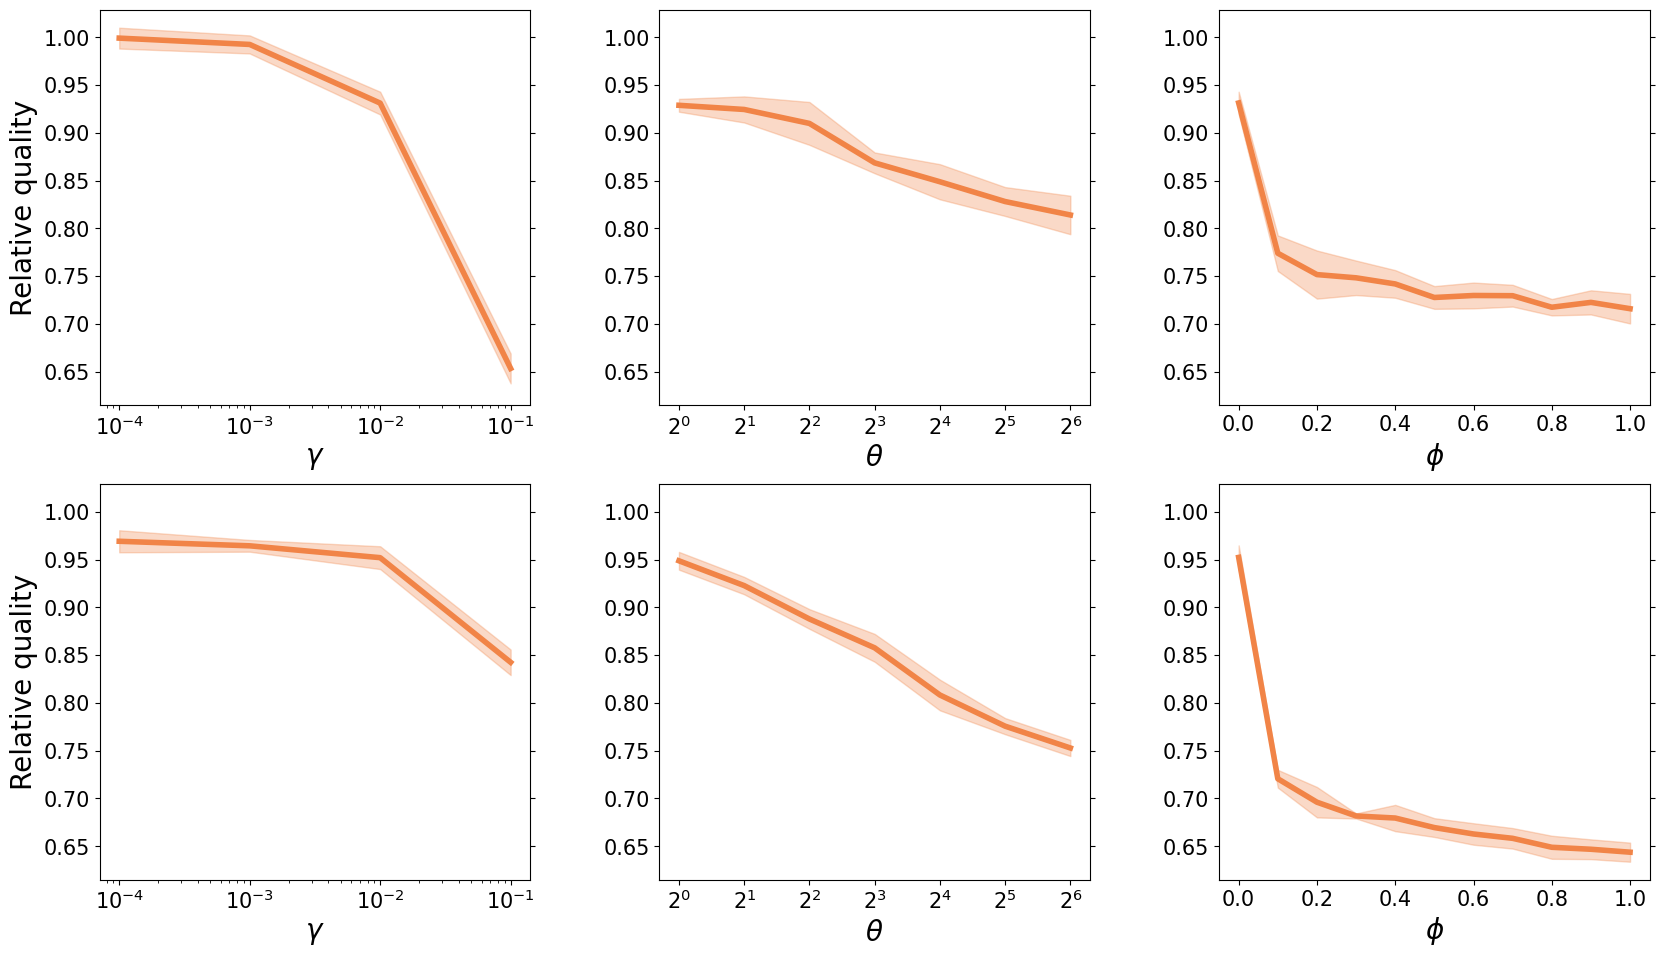

In [153]:
fpath = os.path.join(PLOT_DIR, "robustness")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    2, 3, figsize=(20, 15), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0][0]
draw_lines(ax, og_gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
ax = axs[0][1]
draw_lines(ax, og_thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)

# PHI
ax = axs[0][2]
draw_lines(ax, og_phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

## V1
# GAMMA
ax = axs[1][0]
draw_lines(ax, v1_gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
ax = axs[1][1]
draw_lines(ax, v1_thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[1][2]
draw_lines(ax, v1_phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=0.3, right=None, top=None, wspace=0.3, hspace=None
)
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.5, wspace=0.3)
if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()